In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score
import lightgbm as lgb
from mochi import runXGB,f_beta_01,runLGBM

In [2]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))
print(config.feature_dict.keys())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']
dict_keys(['trade_and_recent_login_comparing', 'recent_login_detail', 'trade_detail_feature', 'login_trade_hist_stats', 'llc_user_habbit', 'hcc_user_habbit', 'hcc_properties', 'hcc_target_encoding', 'login_detail_new_features', 'hcc_mult_target_encoding', 'hcc_user_trade_habbit', 'hcc_trade_properties'])


In [3]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
             config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
            config.feature_dict['hcc_target_encoding']+
                    config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_trade_properties']+
              config.feature_dict['hcc_mult_target_encoding']+
              config.feature_dict['hcc_user_trade_habbit']
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)
#trade_tt_mat[trade_tt_mat==-10]=np.nan

validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

In [4]:
top_features =  config.model_features['model_I_top300']
top_features_ori_index = [features.index(x) for x in top_features]
trade_tt_top = trade_tt_mat[:,top_features_ori_index]

In [5]:
def f_beta_01(preds, train_data, threshold = 0.5):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(labels, preds > threshold,0.1),True

def f_beta_01_xgb(preds, train_data, threshold = 0.5):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(labels, preds > threshold,0.1)

#xgb for binary
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, 
     seed_val=0, early_stop = 20,num_rounds=10000, eta = 0.1,
     subsample = 0.75,colsample_bytree = 0.75,eval_metric = 'auc',feval = None,
     max_depth = 6,cv_dict = None,verbose_eval=True):
    
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = eta
    param['max_depth'] = max_depth
    param['silent'] = 1
    #param['num_class'] = 3
    param['eval_metric'] = eval_metric
    param['min_child_weight'] = 1
    param['subsample'] = subsample
    param['colsample_bytree'] = colsample_bytree
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y,feature_names=feature_names)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y,feature_names=feature_names)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,
        early_stopping_rounds=early_stop,evals_result = cv_dict,
        verbose_eval = verbose_eval,feval = feval)
    else:
        xgtest = xgb.DMatrix(test_X,feature_names=feature_names)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [6]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_top[train_indice], trade_tt_top[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

   
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=None,num_rounds=500,watch_dict=result_dict,feval = f_beta_01)
    """
    preds, model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose_eval=100,eta=0.02,
                          early_stop=None,num_rounds=500,cv_dict=result_dict,feval = f_beta_01_xgb ,max_depth =4)
     """
    
    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.8, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[100]	train's auc: 0.991564	train's fbeta_score_01: 0.948114	test's auc: 0.980625	test's fbeta_score_01: 0.881336
[200]	train's auc: 0.995187	train's fbeta_score_01: 0.95873	test's auc: 0.990065	test's fbeta_score_01: 0.903921
[300]	train's auc: 0.999296	train's fbeta_score_01: 0.96727	test's auc: 0.990508	test's fbeta_score_01: 0.898073
[400]	train's auc: 0.999873	train's fbeta_score_01: 0.974672	test's auc: 0.990319	test's fbeta_score_01: 0.903617
[500]	train's auc: 0.99997	train's fbeta_score_01: 0.989861	test's auc: 0.989837	test's fbeta_score_01: 0.903617
f_beta score for the turn 1 is 0.913935250352
[100]	train's auc: 0.992231	train's fbeta_score_01: 0.967031	test's auc: 0.967445	test's fbeta_score_01: 0.850678
[200]	train's auc: 0.99838	train's fbeta_score_01: 0.970726	test's auc: 0.977005	test's fbeta_score_01: 0.862998
[300]	train's auc: 0.999797	train's fbeta_score_01: 0.976743	test's auc: 0.974224	test's fbeta_score_01: 0.877625
[400]	train's auc: 0.999948	train's fbeta_scor

In [7]:
#finding the best iteration
pd_list = []
for dic in cv_result:
    pd_list.append(pd.DataFrame(dic['test']))
for i in range(len(pd_list)):
    pd_list[i].columns = pd_list[i].columns+'_'+str(i)
validation_result = pd.concat(pd_list,axis = 1)
validation_result['auc_avg'] = validation_result.apply(lambda x : np.mean([x.auc_0,x.auc_1,x.auc_2,x.auc_3,x.auc_4]),axis = 1)

validation_result['fbeta_avg'] = validation_result.apply(lambda x : np.mean([x.fbeta_score_01_0,x.fbeta_score_01_1,
                                                                     x.fbeta_score_01_2,x.fbeta_score_01_3,
                                                                    x.fbeta_score_01_4]),axis=1)

print(validation_result['auc_avg'].idxmax())
print(validation_result['fbeta_avg'].idxmax())

484
177


In [10]:
train_X = trade_tt_mat[config.train_2_6_index]
test_X = trade_tt_mat[config.trade_train_size:]
train_y = train_labels[config.train_2_6_index]

preds_480, model = runLGBM(dev_X, dev_y, val_X, None,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=None,num_rounds=480,watch_dict=result_dict)


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


In [11]:
preds_177, model = runLGBM(dev_X, dev_y, val_X, None,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=None,num_rounds=177,watch_dict=result_dict)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


### result visulization

72
66
62
50


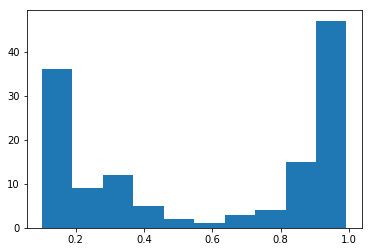

In [12]:
%matplotlib inline
plt.hist(preds_480[preds_480>0.1])
print(np.sum(preds_480>0.5))
print(np.sum(preds_480>0.7))
print(np.sum(preds_480>0.8))
print(np.sum(preds_480>0.9))

70
68
62
54


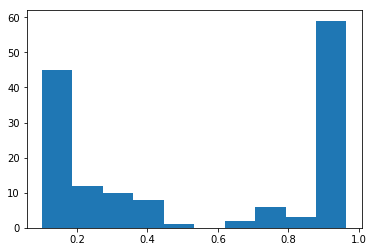

In [13]:
%matplotlib inline
plt.hist(preds_177[preds_177>0.1])
print(np.sum(preds_177>0.5))
print(np.sum(preds_177>0.7))
print(np.sum(preds_177>0.8))
print(np.sum(preds_177>0.9))

In [18]:
    trade_tt_mat[:,features.index('trade_login_rate_360')].min()

-10.0

In [19]:
top_features

['ip_t_encoding',
 'id_t_encoding',
 'city_id_t_encoding',
 'ip_id_t_encoding',
 'device_t_encoding',
 'login_distance_0_al',
 'device_id_t_encoding',
 'login_distance_0',
 'trade_times_360',
 'city_t_encoding',
 'mean_login_distance',
 'type_3_count_30',
 'period_4_login_rate_30',
 'login_success_rate_360',
 'device_repeat_count_360',
 'timelong_std_1',
 'period_4_login_rate_360',
 'timelong_max_1',
 'type_login_0',
 'type_3_rate_30',
 'period_3_login_rate_360',
 'login_distance_1_al',
 'timelong_std_3',
 'timelong_min_30',
 'login_success_rate_30',
 'success_1_rate_30',
 'login_distance_1',
 'timelong_med_360',
 'device_id_city_t_encoding',
 'trade_login_rate_360',
 'login_distance_2_al',
 'type_3_rate_360',
 'device_same_id_login_count_360_t',
 'ip_used_count_7',
 'device_repeat_rate_360',
 'trade_times_30',
 'fail_-2_rate_30',
 'hour',
 'device_used_count_7',
 'timelong_std_15',
 'timelong_min_15',
 'period_3_login_times_360',
 'timelong_med_1',
 'city_used_count_30',
 'timelong_me